In [140]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

# Generate sample data for Wind Direction
with pm.Model() as direction_speed_sampler:
    # Define the circular transform for Wind Direction
    direction_transform = pm.distributions.transforms.circular

    # Define the prior distribution for Wind Direction
    direction = pm.Normal('direction', mu=.5, sigma=.2, transform=direction_transform)

    # Generate the observed data for Wind Direction
    #direction_observed = pm.Normal('direction_observed', mu=direction, sigma=0.1, observed=np.random.randn(100))

    # Generate sample data for Wind Speed

    # Define the prior distribution for Wind Speed
    speed = pm.HalfNormal('speed', sigma=10)

    # Generate the observed data for Wind Speed
    #speed_observed = pm.Normal('speed_observed', mu=speed, sigma=0.1, observed=np.random.randn(100))


In [175]:

def xr_downselect(xr_orig, coordinate, step):
    return xr_orig.sel({f'{coordinate}':xr_orig[f'{coordinate}']%step==0})


In [141]:
with direction_speed_sampler:
    samples = pm.sample(10, chains=1, tune=1000)


Only 10 samples in chain.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [direction, speed]


Sampling 1 chain for 1_000 tune and 10 draw iterations (1_000 + 10 draws total) took 1 seconds.
The number of samples is too small to check convergence reliably.


In [142]:
samples

Inference data with groups:
	> posterior
	> sample_stats

In [143]:
direction_observed = samples.posterior.direction
speed_observed = samples.posterior.speed

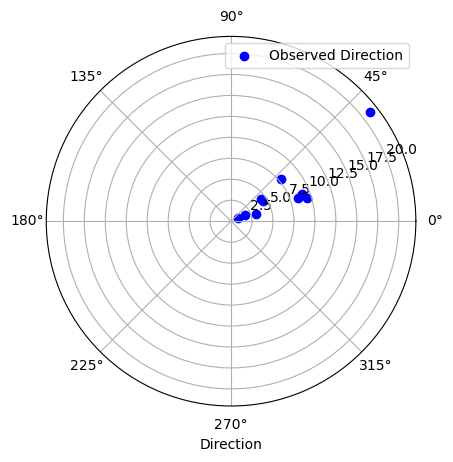

In [144]:

# Create a polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

# Plot the observed direction, with speed magnitude as the radial coordinate
ax.scatter(direction_observed, speed_observed, c='blue', label='Observed Direction')

# Plot the observed speed
#ax.scatter(speed_observed, np.ones_like(speed_observed), c='red', label='Observed Speed')

# Set the labels and title
ax.set_xlabel('Direction')
ax.set_ylabel('')

# Add a legend
ax.legend()

# Show the plot
plt.show()


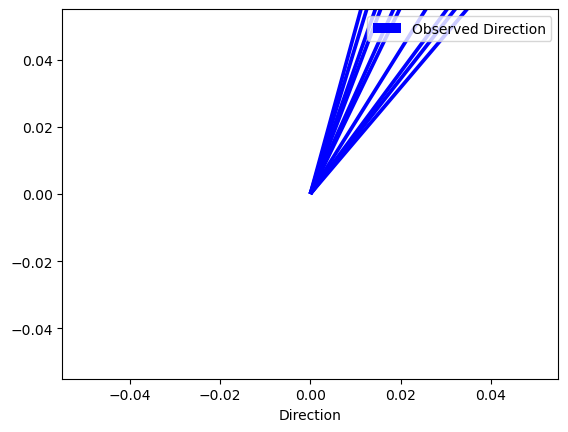

In [145]:


# Create a polar plot
fig, ax = plt.subplots()#subplot_kw={'projection': 'polar'})
# Convert polar coordinates to Cartesian coordinates
arrow_x = speed_observed * np.sin(direction_observed)
arrow_y = speed_observed * np.cos(direction_observed)


# Plot the observed direction as arrows pointing towards the center
ax.quiver(np.zeros_like(arrow_x), np.zeros_like(arrow_y), arrow_x, arrow_y,  angles='uv', scale_units='x', scale=1, color='blue', label='Observed Direction')

# Set the labels and title
ax.set_xlabel('Direction')
ax.set_ylabel('')

# Add a legend
ax.legend()

# Show the plot
plt.show()


In [146]:
# Set up priors for wind direction and speed
pr_mu_direction = 0
pr_sigma_direction = 0.1

pr_sigma_speed = 1

# currently uncorrelated speed and direction
with pm.Model() as direction_speed_model:
    # Define the circular transform for Wind Direction
    direction_transform = pm.distributions.transforms.circular

    # Define the prior distribution for Wind Direction
    direction = pm.Normal('direction', mu=pr_mu_direction, sigma=pr_sigma_direction, transform=direction_transform)

    # Define the prior distribution for Wind Speed
    speed = pm.HalfNormal('speed', sigma=pr_sigma_speed)

    # Generate the observed data for Wind Direction
    direction_obs = pm.Normal('direction_obs', mu=direction, sigma=0.1, observed=direction_observed)

    # Generate the observed data for Wind Speed
    speed_obs = pm.HalfNormal('speed_obs', sigma=speed, observed=speed_observed)



In [147]:
with direction_speed_model:
    trace = pm.sample(1000)
trace

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [direction, speed]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

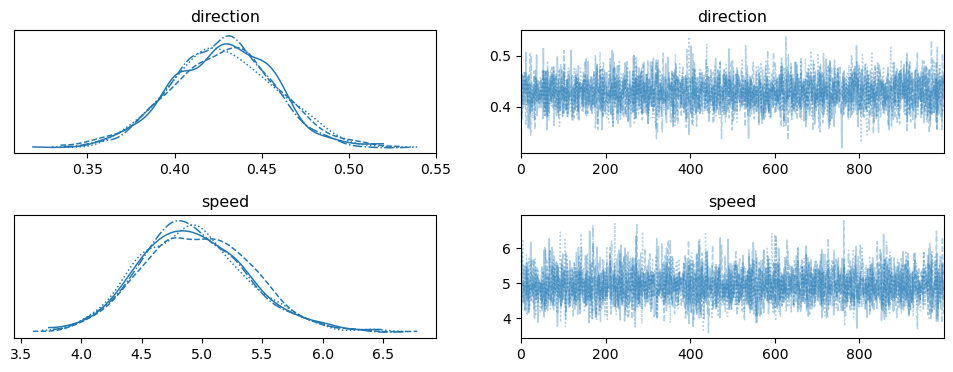

In [148]:
pm.plot_trace(trace, var_names=['direction', 'speed'])
plt.subplots_adjust(hspace=0.5)  # Adjust the vertical spacing between subplots
plt.show()


In [150]:
with direction_speed_model:
    posterior_predictive = pm.sample_posterior_predictive(trace=trace)
    trace.extend(posterior_predictive)


Sampling: [direction_obs, speed_obs]


In [179]:
# Downsample the trace.posterior using xarray
downsampled_trace = xr_downselect(trace.posterior_predictive.sel(chain=0), 'draw', 200)

# Print the downsampled trace
print(downsampled_trace)


<xarray.Dataset>
Dimensions:              (draw: 5, direction_obs_dim_2: 1,
                          direction_obs_dim_3: 10, speed_obs_dim_2: 1,
                          speed_obs_dim_3: 10)
Coordinates:
    chain                int32 0
  * draw                 (draw) int32 0 200 400 600 800
  * direction_obs_dim_2  (direction_obs_dim_2) int32 0
  * direction_obs_dim_3  (direction_obs_dim_3) int32 0 1 2 3 4 5 6 7 8 9
  * speed_obs_dim_2      (speed_obs_dim_2) int32 0
  * speed_obs_dim_3      (speed_obs_dim_3) int32 0 1 2 3 4 5 6 7 8 9
Data variables:
    direction_obs        (draw, direction_obs_dim_2, direction_obs_dim_3) float64 ...
    speed_obs            (draw, speed_obs_dim_2, speed_obs_dim_3) float64 1.6...
Attributes:
    created_at:                 2023-12-08T03:34:43.831263
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.8.2


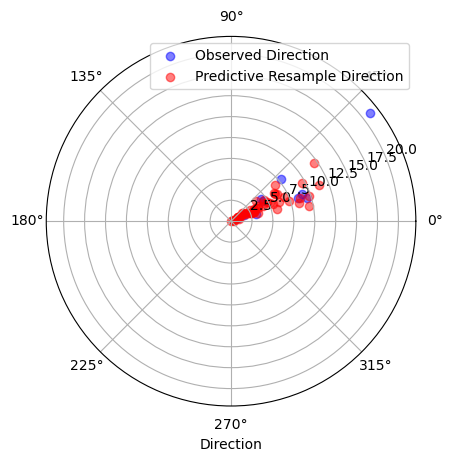

In [186]:
# Create a polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

# Plot the observed direction, with speed magnitude as the radial coordinate
ax.scatter(direction_observed, speed_observed, c='blue', label='Observed Direction', alpha=0.5)

#plot the posterior predictive
ax.scatter(downsampled_trace['direction_obs'], downsampled_trace['speed_obs'], c='red', label='Predictive Resample Direction', alpha=0.5)

# Set the labels and title
ax.set_xlabel('Direction')
ax.set_ylabel('')

# Add a legend
ax.legend()

# Show the plot
plt.show()
